In [1]:
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../PRNet")
from api import PRN
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' # cpu
prn = PRN(is_dlib = True, prefix="../../PRNet")
from utils.render import render_texture
from utils.rotate_vertices import frontalize
from utils.estimate_pose import estimate_pose
import numpy as np
import dlib
sys.path.insert(0, "../../deepfeatinterp")
import alignface

import alignface

import time
def warp_face(img_in, img_ref):
    #img_in is HD image
    # img_ref is synthesis image
    # Calculate position map and get pose and rotation matrix
    pos1 = prn.process(img_in) 
    vertices1 = prn.get_vertices(pos1)
    cam_mat1, pose1, R1 = estimate_pose(vertices1)
    pos2 = prn.process(img_ref) 
    vertices2 = prn.get_vertices(pos2)
    cam_mat2, pose2, R2 = estimate_pose(vertices2)

    # Rotation 3D vertices
    warp_vertices = np.matmul(np.matmul(vertices2,R2), np.linalg.inv(R1)) 

    # Do translation
    center2_warp_pt = np.mean(warp_vertices, axis=0)
    center1_pt = np.mean(vertices1, axis=0)
    warp_vertices = warp_vertices - (center2_warp_pt - center1_pt)

    # Render new synthesis image after doing transformation
    # t1 = time.time()
    texture_ref = cv2.remap(img_ref/255.0, pos2[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
    # print("Texture from pos map: ", time.time()-t1)

    [h, w, c] = img_ref.shape
    # t1 = time.time()
    
    color = prn.get_colors_from_texture(texture_ref)
    # print("Get color of texture: ", time.time()-t1)
    
    color_mask = np.ones((warp_vertices.shape[0], 1))
    t1 = time.time()
    new_image = render_texture(warp_vertices.T, color.T, prn.triangles.T, h, w, c = 3)
    print("Time render: ", time.time()-t1)
    facemask = render_texture(warp_vertices.T, color_mask.T, prn.triangles.T, h, w, c = 3)

    # Using seamlessCloning to blending images
    vis_ind = np.argwhere(facemask>0)
    vis_min = np.min(vis_ind, 0)
    vis_max = np.max(vis_ind, 0)
    center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))
    output = cv2.seamlessClone((new_image*255).astype(np.uint8),(img_in).astype(np.uint8), (facemask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)

    return output

model_path = "/home/vuthede/Downloads/shape_predictor_81_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_path)
face_d,face_p=alignface.load_face_detector(predictor_path="/home/vuthede/AI/deepfeatinterp/models/shape_predictor_68_face_landmarks.dat")


def get_landmark(im1):
    det0 = detector(im1, 0)[0]
    shape = predictor(im1, det0)
    landmarks = np.matrix([[p.x, p.y] for p in shape.parts()])
    landmarks = np.array(landmarks)
    return landmarks

def draw_landmark(im, l, color =(0,255,0)):
    im_ = im.copy()
    for i in l:
        cv2.circle(im_, (i[0],i[1]), 3,color, -1)

    return im_

def warp_face_2D(img_in, img_ref):
    cv2.imwrite("tmp.png", img_ref)
    cv2.imwrite("tmp2.png", img_in)

    lm1 = get_landmark(img_ref)
    lm2 = get_landmark(img_in)
    # template,original=alignface.detect_landmarks("tmp.png",face_d,face_p)
    # template2,original2=alignface.detect_landmarks("tmp2.png",face_d,face_p)

    M,loss=alignface.fit_face_landmarks(lm1[:,::-1],lm2[:,::-1], landmarks=list(range(81)), scale_landmarks=[0,16],location_landmark=30,image_dims=img_in.shape[:2])

    warp_image = alignface.warp_to_template(img_ref,M,border_value=(0.5,0.5,0.5),image_dims=img_in.shape)

    # cv2.imshow("warp image raw:", warp_image)

     # Find convex hull
    hull1 = []
    hull2 = []

   

    # template = np.array(template[:,::-1]).astype(int)
    # template2 = np.array(template2[:,::-1]).astype(int)

    show = draw_landmark(img_ref, lm1)
    # cv2.imshow("Lmk:", show)

    # print(template)
    # print(template.shape)

    hullIndex = cv2.convexHull(lm1, returnPoints = False)          
    for i in range(0, len(hullIndex)):
        hull1.append(lm1[int(hullIndex[i])])
        hull2.append(lm2[int(hullIndex[i])])
    
    hull1 = np.array(hull1)
    hull2 = np.array(hull2)

    mouth_mask = np.zeros(img_ref.shape, img_ref.dtype)
    cv2.fillPoly(mouth_mask, [hull2], (255, 255, 255))
    # cv2.imshow("mask:", mouth_mask)

    r = cv2.boundingRect(np.float32(hull2))    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    clone = cv2.seamlessClone(warp_image, img_in, mouth_mask, center, cv2.NORMAL_CLONE)

    return clone



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `layer.__call__` method instead.





INFO:tensorflow:Restoring parameters from ../../PRNet/Data/net-data/256_256_resfcn256_weight


# Test demo

In [3]:
cap_hd = cv2.VideoCapture("../cropobamafullhd10s.mp4")
cap_syn = cv2.VideoCapture("../resultobamafullhd10s.mp4")

i = 0
while True:
    i +=1

    if i%15:
        ret1, hd = cap_hd.read()
        ret2, syn = cap_syn.read()

        if not ret1 or not ret2:
            print("Quit")
            # out.release()
            break

        # warp, transform = warp_face_2D(hd, syn)
        warp  = warp_face_2D(hd, syn)


        concat = np.hstack([hd, syn, warp])
        # concat = np.hstack([hd, syn,transform, warp])


        cv2.imshow("hd", hd)
        cv2.imshow("syn", syn)
        cv2.imshow("warp", warp)
        # cv2.imshow("transform", transform)
        cv2.imshow("concat", concat)
        # out.write(concat)




        k = cv2.waitKey(0)
        if k==27:
            # out.release()
            break

# out.release()
cv2.destroyAllWindows()
    

In [6]:
cap_hd = cv2.VideoCapture("../cropobamafullhd10s.mp4")
cap_syn = cv2.VideoCapture("../resultobamafullhd10s.mp4")
out = cv2.VideoWriter('./data_playing_2d.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (256*4, 256))

i = 0
while True:
    i +=1

    if i%15:
        ret1, hd = cap_hd.read()
        ret2, syn = cap_syn.read()

        if not ret1 or not ret2:
            print("Quit")
            out.release()
            break

        warp, transform = warp_face_2D(hd, syn)

        concat = np.hstack([hd, syn,transform, warp])

        cv2.imshow("hd", hd)
        cv2.imshow("syn", syn)
        cv2.imshow("warp", warp)
        cv2.imshow("transform", transform)
        cv2.imshow("concat", concat)
        out.write(concat)




        k = cv2.waitKey(0)
        if k==27:
            out.release()
            break

out.release()
cv2.destroyAllWindows()
    

In [13]:
from math import log10, sqrt 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

def check_valid_data(h_im, l_im):
    h_im = cv2.resize(h_im, (128,128), cv2.INTER_CUBIC)
    h_im = cv2.resize(h_im, (512,512), cv2.INTER_CUBIC)
    l_im = cv2.imread(l)
    l_im = cv2.resize(l_im, (512,512))

    # MOuth
    choose = [51,48,54,57]

    h_lmk = get_landmark(h_im)[choose]
    x1,y1 = np.min(h_lmk, axis=0)
    x2,y2 = np.max(h_lmk, axis=0)
    padx = int(0.2*(x2-x1))
    pady = int(0.2*(y2-y1))
 
    x1 -= padx
    x2 += padx
    y1 -= pady
    y2 += pady

    h_im_selected = np.zeros(h_im.shape)
    l_im_selected = np.zeros(l_im.shape)
    h_im_selected[y1:y2, x1:x2] = h_im[y1:y2, x1:x2]
    l_im_selected[y1:y2, x1:x2] = l_im[y1:y2, x1:x2]


    # Eye
    choose = [28, 17, 26]
    h_lmk = get_landmark(h_im)
    other_lmk = list([h_lmk[71]//2 + h_lmk[27]//2])
    h_lmk = np.array(list(h_lmk[choose]) + other_lmk)
    x1,y1 = np.min(h_lmk, axis=0)
    x2,y2 = np.max(h_lmk, axis=0)
    padx = int(0.2*(x2-x1))
    pady = int(0.2*(y2-y1))
 
    x1 -= padx
    x2 += padx
    y2 += pady

    h_im_selected[y1:y2, x1:x2] = h_im[y1:y2, x1:x2]
    l_im_selected[y1:y2, x1:x2] = l_im[y1:y2, x1:x2]

    h_im_selected = h_im_selected.astype(np.uint8)
    l_im_selected = l_im_selected.astype(np.uint8)


    psnr_loss = PSNR(h_im_selected, l_im_selected)
    print(psnr_loss)
    if psnr_loss > 40.5:
        print("Data pair invalid")   
        return False
    
    # print("Data pair valid")
    return True

def prepare_data_for_face_res(highresvideo, lowressyn, data_output, prefix='batch1', downsample=2, warp2d=True, warp3d=False):
    """
    /highres = 512x512
    /lowres  = 256x256 -->128x128
    /dataoutput = /--highres
                  /--lowres_warp2d
                  /--lowres_warp3d
    """
    
    highres_out = "highres"
    lowres_warp2d_out = "lowres_warp2d"
    lowres_warp3d_out = "lowres_warp3d"

    cap_high = cv2.VideoCapture(highresvideo)
    cap_low = cv2.VideoCapture(lowressyn)
    
    if not os.path.isdir(data_output):
        os.makedirs(data_output + "/" + highres_out)
        os.makedirs(data_output + "/" + lowres_warp2d_out)
        os.makedirs(data_output + "/" + lowres_warp3d_out)

   

    i = 0
    while True:
        ret1, hr = cap_high.read()
        ret2, lr = cap_low.read()

        if i%downsample==0:

            assert hr.shape[:2]==(512,512) and lr.shape[:2]==(256,256) 
            hr_tmp = cv2.resize(hr, (256, 256))

            if warp2d:
                lr_warp2d = warp_face_2D(hr_tmp, lr)
                lr_warp2d = cv2.resize(lr_warp2d, (128, 128))

                if not check_valid_data(hr, lr_warp2d):
                    continue

                cv2.imwrite(f'{data_output}/{lowres_warp2d_out}/{prefix}_{i}.png', lr_warp2d)
            if warp3d:
                lr_warp3d = warp_face(hr_tmp, lr)
                lr_warp3d = cv2.resize(lr_warp3d, (128, 128))

                if not check_valid_data(hr, lr_warp3d):
                    continue

                cv2.imwrite(f'{data_output}/{lowres_warp3d_out}/{prefix}_{i}.png', lr_warp3d)

            cv2.imwrite(f'{data_output}/{highres_out}/{prefix}_{i}.png', hr)


        i += 1


prepare_data_for_face_res(highresvideo="batches_highres/2.mp4", lowressyn="synthesis_guided_by_512x512/2.mp4",
                          data_output="train_data_with_filter", prefix='batch2',
                          downsample=2, warp2d=True, warp3d=False)





37.793541376391964
37.81562901873352
37.71712275920539
37.93422764123028
37.6663115197738
37.7985727629858
37.9491402098312
37.65891918034619
38.17291895395047
38.00615093637537
37.93855877743596
37.7963633682116
38.057144735184494
37.970973121136154
38.27989722327685
38.383362860664604
37.6745784622257
37.49761762135811
37.75754077093013
38.16493232939579
38.5343776538036
38.31831514494279
38.325038307395054
38.41336045664664
38.35124821116197
38.0720039748913
37.96063418980255
37.77751726354377
37.61668243326778
37.626910824855536
37.55027354909133
37.40265313597081
37.67569175752962
37.625031808394404
37.976428156628444
37.93277591895691
37.40912156678607
37.69309252361839
38.18354615267733
38.08458216683756
37.91985740801688
37.56236443622937
37.689177865283696
37.74069605153915
37.898508601186194
38.06195138708685
37.908158531560886
37.840190320311635
38.01674523869505
37.555319461325574
37.37065635485334
37.62216028355287
37.65852190721235
37.62464696106768
37.53333403192508
37.7

KeyboardInterrupt: 

# Test data

In [5]:
import glob
import cv2

highres = glob.glob("./train_data/highres/*.png")
for h in highres:
    l = h.replace("highres", "lowres_warp2d")
    h_im = cv2.imread(h)
    cv2.imshow("High", h_im)
    l_im = cv2.imread(l)
    l_im = cv2.resize(l_im, (512,512))
    cv2.imshow("Low",l_im)

    k = cv2.waitKey(0)

    if k ==27:
        break

cv2.destroyAllWindows()

In [2]:
import numpy as np
import glob

def get_loss_lmks(data_path):
    highres = glob.glob(data_path + "/highres/*.png")
    losses = {}
    for h in highres:
        l = h.replace("highres", "lowres_warp2d")
        h_im = cv2.imread(h)
        l_im = cv2.imread(l)
        l_im = cv2.resize(l_im, (512,512))

        h_lmk = get_landmark(h_im)
        l_lmk = get_landmark(l_im)
        losses[f'{os.path.basename(h)}'] = np.linalg.norm(h_lmk-l_lmk)
    
    return losses


losses = get_loss_lmks("./train_data")




In [4]:
import pickle

pickle.dump(losses, open("losses.pickle", 'wb'))

In [2]:
import pickle

losses = pickle.load(open("losses.pickle", 'rb'))

In [5]:
# losses

(array([ 10.,  29., 119., 144., 158., 341., 209., 206., 220.,  99.,  63.,
         56.,  21.,  21.,  10.,   9.,   7.,   7.,   7.,   7.,   3.,   6.,
          3.,   3.,   2.,   8.,   3.,   0.,   1.,   0.,   2.,   0.,   5.,
          0.,   1.,   2.,   0.,   1.,   2.,   2.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   2.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  9.  ,  11.34,  13.68,  16.02,  18.36,  20.7 ,  23.04,  25.38,
         27.72,  30.06,  32.4 ,  34.74,  37.08,  39.42,  41.76,  44.1 ,
         46.44,  48.78,  51.12,  53.46,  55.8 ,  58.14,  60.48,  62.82,
         65.16,  67.5 ,  69.84,  72.18,  74.52,  76.86,  79.2 ,  81.54,
         83.88,  86.22,  88.56

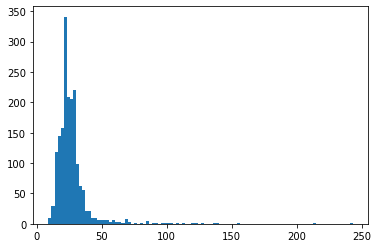

In [3]:
err = np.array(list(losses.values())).astype(int)
plt.hist(err, bins=100)

In [3]:
def get_file_have_big_loss(losses):
    mismatch_cases = []
    los = []

    for k,v in losses.items():
        if v <30:
            mismatch_cases.append(k)
            los.append(v)
    
    return mismatch_cases, los

mismatch_keys, los = get_file_have_big_loss(losses)
len(mismatch_keys)

1372

In [4]:
from math import log10, sqrt 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
def check_valid_data(h_im, l_im):
    h_im = cv2.resize(h_im, (128,128), cv2.INTER_CUBIC)
    h_im = cv2.resize(h_im, (512,512), cv2.INTER_CUBIC)
    l_im = cv2.imread(l)
    l_im = cv2.resize(l_im, (512,512))

    # MOuth
    choose = [51,48,54,57]

    h_lmk = get_landmark(h_im)[choose]
    x1,y1 = np.min(h_lmk, axis=0)
    x2,y2 = np.max(h_lmk, axis=0)
    padx = int(0.2*(x2-x1))
    pady = int(0.2*(y2-y1))
 
    x1 -= padx
    x2 += padx
    y1 -= pady
    y2 += pady

    h_im_selected = np.zeros(h_im.shape)
    l_im_selected = np.zeros(l_im.shape)
    h_im_selected[y1:y2, x1:x2] = h_im[y1:y2, x1:x2]
    l_im_selected[y1:y2, x1:x2] = l_im[y1:y2, x1:x2]


    # Eye
    choose = [28, 17, 26]
    h_lmk = get_landmark(h_im)
    other_lmk = list([h_lmk[71]//2 + h_lmk[27]//2])
    h_lmk = np.array(list(h_lmk[choose]) + other_lmk)
    x1,y1 = np.min(h_lmk, axis=0)
    x2,y2 = np.max(h_lmk, axis=0)
    padx = int(0.2*(x2-x1))
    pady = int(0.2*(y2-y1))
 
    x1 -= padx
    x2 += padx
    y2 += pady

    h_im_selected[y1:y2, x1:x2] = h_im[y1:y2, x1:x2]
    l_im_selected[y1:y2, x1:x2] = l_im[y1:y2, x1:x2]

    h_im_selected = h_im_selected.astype(np.uint8)
    l_im_selected = l_im_selected.astype(np.uint8)


    psnr_loss = PSNR(h_im_selected, l_im_selected)

    if psnr_loss > 40.5:
        return False
    
    return True



In [8]:
import glob
import cv2

highres = ["./train_data/highres/" + k for k in mismatch_keys]

PSNR_loss = []
for h,lo in zip(highres, los):
    l = h.replace("highres", "lowres_warp2d")
    h_im = cv2.imread(h)
    h_im = cv2.resize(h_im, (128,128), cv2.INTER_CUBIC)
    h_im = cv2.resize(h_im, (512,512), cv2.INTER_CUBIC)


    # h_im = h_im[150:-100, 140:-140]

    # h_im = cv2.resize(h_im, (256,256))

    # cv2.imshow("High", h_im)
    l_im = cv2.imread(l)
    # l_im = cv2.resize(l_im, (256,256))
    l_im = cv2.resize(l_im, (512,512))
    # l_im = l_im[150:-100, 140:-140]

    # MOuth
    # choose = [33,48,54,57]
    choose = [51,48,54,57]

    h_lmk = get_landmark(h_im)[choose]
    x1,y1 = np.min(h_lmk, axis=0)
    x2,y2 = np.max(h_lmk, axis=0)
    padx = int(0.2*(x2-x1))
    pady = int(0.2*(y2-y1))
    # padx=0
    # pady=0
    x1 -= padx
    x2 += padx
    y1 -= pady
    y2 += pady

    # print(x1,y1,x2,y2)
    
    # h_im = h_im[y1:y2,x1:x2]
    # h_im_selected = h_im[y1:y2, x1:x2]
    h_im_selected = np.zeros(h_im.shape)
    l_im_selected = np.zeros(l_im.shape)

    h_im_selected[y1:y2, x1:x2] = h_im[y1:y2, x1:x2]
    l_im_selected[y1:y2, x1:x2] = l_im[y1:y2, x1:x2]

    # print("eeeeeeeeeeeeee")

    # Eye
    choose = [28, 17, 26]
    h_lmk = get_landmark(h_im)
    other_lmk = list([h_lmk[71]//2 + h_lmk[27]//2])
    h_lmk = np.array(list(h_lmk[choose]) + other_lmk)
    x1,y1 = np.min(h_lmk, axis=0)
    x2,y2 = np.max(h_lmk, axis=0)
    padx = int(0.2*(x2-x1))
    pady = int(0.2*(y2-y1))
    # padx=0
    # pady=0
    x1 -= padx
    x2 += padx
    y2 += pady
    
    # print(x1,y1,x2,y2)

    # h_im = h_im[y1:y2,x1:x2]
    # h_im_selected = h_im[y1:y2, x1:x2]
    # h_im_selected = np.zeros(h_im.shape)
    # l_im_selected = np.zeros(l_im.shape)

    h_im_selected[y1:y2, x1:x2] = h_im[y1:y2, x1:x2]
    l_im_selected[y1:y2, x1:x2] = l_im[y1:y2, x1:x2]

    h_im_selected = h_im_selected.astype(np.uint8)
    l_im_selected = l_im_selected.astype(np.uint8)



    # padx=0.2*(x2-x1)
    # pady=0.2*(y2-x1)
    # x1-=padding
    # y1-=padding

    # l_lmk = get_landmark(l_im)[choose]
    # x3,y3 = np.min(l_lmk, axis=0)
    # x4,y4 = np.max(l_lmk, axis=0)
    # l_im = l_im[y1:y2,x1:x2]

    psnr_loss = PSNR(h_im_selected, l_im_selected)
    PSNR_loss.append(psnr_loss)

    # if PSNR(h_im_selected, l_im_selected) > 38.2:
    #     continue

    # cv2.imshow("Low",l_im)

    con = np.hstack([h_im_selected, l_im_selected])
    cv2.imshow("imh",con)

    print("Loss: ", lo, "PSRN: ", psnr_loss)
    

    k = cv2.waitKey(1)

    if k ==27:
        break

cv2.destroyAllWindows()

Loss:  24.372115213907882 PSRN:  40.042018749841716
Loss:  16.61324772583615 PSRN:  39.960577501827785
Loss:  21.840329667841555 PSRN:  40.54692510143038
Loss:  19.544820285692065 PSRN:  39.65236084420024
Loss:  15.264337522473747 PSRN:  40.94909965556563
Loss:  21.6794833886788 PSRN:  39.462547357782185
Loss:  28.071337695236398 PSRN:  39.68357133863745
Loss:  23.68543856465402 PSRN:  40.123882072285156
Loss:  24.24871130596428 PSRN:  39.94544266201834
Loss:  25.826343140289914 PSRN:  39.38525680936716
Loss:  24.474476501040833 PSRN:  40.183335026284155
Loss:  17.406895185529212 PSRN:  39.81687304886526
Loss:  26.057628441590765 PSRN:  40.327535207353606
Loss:  19.72308292331602 PSRN:  39.5557405289406
Loss:  22.538855339169288 PSRN:  39.80117683988412
Loss:  28.948229652260256 PSRN:  39.62646883680825
Loss:  18.920887928424502 PSRN:  39.35785432155556
Loss:  25.98076211353316 PSRN:  39.34047897341652
Loss:  18.894443627691185 PSRN:  39.74338432751822
Loss:  28.24889378365107 PSRN:  3

(array([ 1.,  2.,  1.,  4.,  5.,  8., 11.,  6., 15.,  9., 12., 29., 30.,
        35., 44., 46., 46., 56., 49., 71., 60., 72., 61., 60., 61., 48.,
        52., 45., 43., 41., 36., 39., 36., 23., 22., 22., 21., 16., 16.,
        14., 13., 18., 19.,  6.,  5.,  6.,  7.,  3.,  3.,  2.,  2.,  3.,
         1.,  1.,  2.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  2.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([38.7458397 , 38.79358552, 38.84133134, 38.88907717, 38.93682299,
        38.98456881, 39.03231463, 39.08006045, 39.12780627, 39.17555209,
        39.22329792, 39.27104374, 39.31878956, 39.36653538, 39.4142812 ,
        39.46202702, 39.50977285, 39.55751867, 39.60526449, 39.65301031,
        39.70075613, 39.74850195, 39.79624777, 39.8439936 , 39.89173942,
        39.93948524, 39.98723106, 40.03497688, 40.0827227 , 40.130468

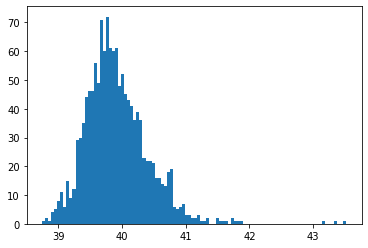

In [9]:
plt.hist(PSNR_loss, bins=100)

In [18]:
a = np.array([[1,2],[1,4]])
a

array([[1, 2],
       [1, 4]])

In [19]:
np.min(a, axis=0)


array([1, 2])

# Divide batches

In [5]:
import cv2
def concat_video_data(video, output_video):
    out = cv2.VideoWriter(f'./{output_video}',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (512, 512))    

    period = [[0,43*30], [5*60*30,9*60*30], [10*60*30, 13*60*30]]
    cap = cv2.VideoCapture(video)
    x1 = 685
    y1 = 85 
    x2 = 1250
    y2 = 650

    for p in period:
        cap.set(1, p[0])
        num_frames = p[1]-p[0]
        for i in range(num_frames):
            ret, img = cap.read()
            img = img[y1:y2, x1:x2]
            img = cv2.resize(img, (512,512))
            out.write(img)
        print("Finish one period")
    
    out.release()
    cv2.destroyAllWindows()

concat_video_data("../obama_fullhd.mp4", output_video="concat_obama_512x512.mp4")



Finish one period
Finish one period
Finish one period


In [7]:
cap = cv2.VideoCapture("concat_obama_512x512.mp4")
ret, img = cap.read()
ret

True

In [11]:
import os
import cv2

def cut_batch_data(video, output_dir, down_to_256=False):
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
        
    cap = cv2.VideoCapture(video)
    batch = 0
    i = 0
    while True:
        ret, img = cap.read()
        # print(img.shape)

        if not ret:
            out.release()
            break
            
        if i%(60*30*2)==0:
            batch +=1
            if down_to_256:
                out = cv2.VideoWriter(f'./{output_dir}/{batch}.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (256, 256))    
            else:
                out = cv2.VideoWriter(f'./{output_dir}/{batch}.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (512, 512))    

            print("New batch")

        out.write(img)
        i+=1

    out.release()


cut_batch_data("./concat_obama_512x512.mp4",output_dir="batches_highres")



New batch
New batch
New batch
New batch


In [12]:
cap = cv2.VideoCapture("./batches_highres/4.mp4")
ret, img = cap.read()
ret

True

In [ ]:
import glob

def downscale(in_dir, out_dir):
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
        
    files = glob.glob(in_dir + "/*.png")
    for file in files:
        img = cv2.imread(file)
        img = cv2.resize(img, (128,128))
        cv2.imwrite(output_dir + "/" + os.path.basename(file), img)
        print("Saved 1 file")
    
    print("Finish")
